# 

# Case Study: Pre-Processing Data

In this chapter, we put some of our R skills together in a case study.
This case study focuses on data cleaning and pre-processing. We use the
`tb_diagnosis_raw` data from the **HDSinRdata** package. This data
contains information on 1,634 patients in rural South Africa who
presented at a health clinic with tuberculosis-related symptoms and were
tested for tuberculosis (TB) using Xpert MTB/RIF. Our goal is to clean
this data to reflect the pre-processing described in @baik2020clinical.
This paper uses this data to derive a simple risk score model for
screening patients for treatment while awaiting Xpert results. We use
the **tidyverse** packages as well as the summary tables from
**gtsummary**.

In [ ]:
library(HDSinRdata)
library(tidyverse)
library(gt)
library(gtsummary)

To begin, read in the data and review the description of the original
columns. Some things to note in the data documentation are the ways
unknown, missing, or refused values are coded as well as how some of the
columns are related to each other.

In [ ]:
# Read in data
data("tb_diagnosis_raw")

# Inspect variable descriptions
# ?tb_diagnosis_raw

To start, we select variables needed for our analysis. In particular, we
drop columns related to the participation in the survey and about
seeking care. Since some of these variables contain long or vague names,
we also rename most of the variables.

In [ ]:
# Select variables and rename
tb_df <- tb_diagnosis_raw %>% 
  select(c(xpert_status_fac, age_group, sex, hiv_status_fac,
           other_conditions_fac___1, other_conditions_fac___3,
           other_conditions_fac___88, other_conditions_fac___99,
           symp_fac___1, symp_fac___2, symp_fac___3, symp_fac___4, 
           symp_fac___99, length_symp_unit_fac, length_symp_days_fac,
           length_symp_wk_fac, length_symp_mnt_fac, length_symp_yr_fac,
           smk_fac, dx_tb_past_fac, educ_fac)) %>%
    rename(tb = xpert_status_fac, hiv_pos = hiv_status_fac,
           cough = symp_fac___1, fever = symp_fac___2, 
           weight_loss = symp_fac___3, night_sweats = symp_fac___4, 
           symptoms_missing = symp_fac___99,
           ever_smoke = smk_fac, 
           past_tb = dx_tb_past_fac, education = educ_fac)

We then use a summary table to understand the initial distributions of
the variables observed. This also highlights where we have missing or
unknown data.

In [ ]:
tbl_summary(tb_df) %>%
  as_gt()

One observation from the table is that the coding of variables is
inconsistent, with some using 0/1 and others using 1/2. We want to
standardize how these variables are represented. To start, we update our
`tb` column. Additionally, we create a column `male` from the previous
column `sex` to make the reference level clear. We can then drop the
`sex` column.

In [ ]:
# Re-code binary variables to 0/1 instead of 1/2
tb_df$tb <- case_when(tb_df$tb == 1 ~ 1, 
                      tb_df$tb == 2 ~ 0)

tb_df$male <- case_when(tb_df$sex == 1 ~ 1, 
                        tb_df$sex == 2 ~ 0)
tb_df <- tb_df %>% select(-c(sex))

Diabetes is another variable that should be coded this way. In the raw
data, several columns correspond to this question about other medical
conditions. Therefore, we need to use the columns
`other_conditions_fac___88` and `other_conditions_fac___99` to check
whether the participant did not answer the question when interpreting
the 0/1 value for diabetes.

In [ ]:
# Re-code diabetes to check if missing
tb_df$diabetes <- case_when(tb_df$other_conditions_fac___3 == 1 ~ 1,
                            tb_df$other_conditions_fac___1 == 1 ~ 0,
                            tb_df$other_conditions_fac___88 == 1 ~ NA,
                            tb_df$other_conditions_fac___99 == 1 ~ NA,
                            TRUE ~ 0)
tb_df <- tb_df %>% select(-c(other_conditions_fac___1,
                             other_conditions_fac___3,
                             other_conditions_fac___88,
                             other_conditions_fac___99))
table(tb_df$diabetes)


   0    1 
1541   52 

Next, we similarly code our variables about HIV status, smoking, and
whether the patient has ever been diagnosed with tuberculosis before.
For these variables, if the patient answered that they did not know if
their HIV status or had tested positive for TB, we code these as 0 to be
consistent with the paper.

In [ ]:
# Re-code variables with missing or refused values
tb_df$hiv_pos <- case_when((tb_df$hiv_pos == 1) ~ 1, 
                           tb_df$hiv_pos %in% c(2,77) ~ 0,
                           tb_df$hiv_pos == 88 ~ NA)

tb_df$ever_smoke <- case_when(tb_df$ever_smoke %in% c(1,2) ~ 1,
                              tb_df$ever_smoke == 3 ~ 0,
                              tb_df$ever_smoke == 99 ~ NA)

tb_df$past_tb <- case_when(tb_df$past_tb == 1 ~ 1, 
                           tb_df$past_tb %in% c(2,77) ~ 0)

The next variable we clean is `education`. First, we need to code NA
values correctly. We can then observe the distribution of years of
education.

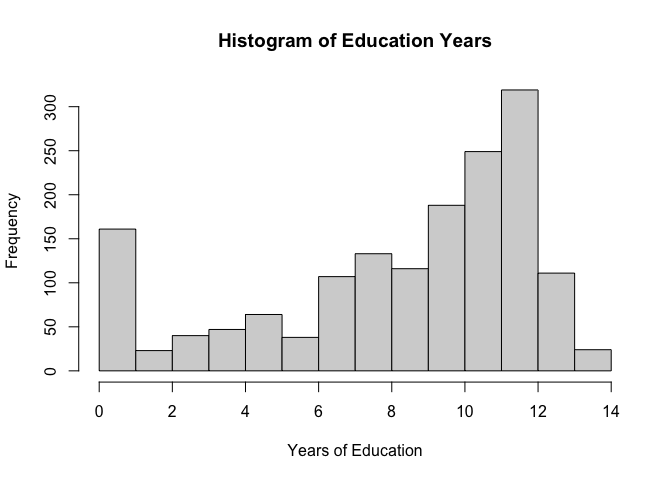

In [ ]:
# Code NA values and look at education distribution
tb_df$education[tb_df$education == 99] <- NA
hist(tb_df$education, xlab = "Years of Education", 
     main = "Histogram of Education Years")

For our purposes, we want to represent education as whether a person has
a high school education or less.

In [ ]:
# Categorize education to HS and above
tb_df$hs_less <- case_when(tb_df$education <= 12 ~ 1,
                           tb_df$education > 12 ~ 0,
                           TRUE ~ NA)
tb_df <- tb_df %>% select(-c(education))

There are several variables in the data related to how long a person has
experienced symptoms. In the following code, we can see that the unit of
the symptoms, recorded in `length_symp_unit_fac`, determines which other
column is entered. For example, if `length_symp_unit_fac == 1`, then the
only column without an NA value is `length_symp_days_fc`.

In [ ]:
tb_df %>%
  group_by(length_symp_unit_fac) %>%
  summarize(missing_days = sum(is.na(length_symp_days_fac))/n(),
            missing_wks = sum(is.na(length_symp_wk_fac))/n(),
            missing_mnt = sum(is.na(length_symp_mnt_fac))/n(),
            missing_yr = sum(is.na(length_symp_yr_fac))/n())

# A tibble: 6 × 5
  length_symp_unit_fac missing_days missing_wks missing_mnt missing_yr
                 <int>        <dbl>       <dbl>       <dbl>      <dbl>
1                    1            0           1           1          1
2                    2            1           0           1          1
3                    3            1           1           0          1
4                    4            1           1           1          0
5                   77            1           1           1          1
6                   NA            1           1           1          1

Additionally, these measurements are positive integer values.

In [ ]:
min(tb_df$length_symp_days_fac, na.rm = TRUE)

[1] 1

[1] TRUE

This allows us to create a new variable that represents whether or not
someone has had symptoms for more than two weeks. In our `case_when()`
function call, we first check whether the duration is missing before
checking for the cases when symptoms would be less than two weeks.

In [ ]:
# Categorize number of weeks experiencing symptoms
tb_df <- tb_df %>%
  mutate(case_when((length_symp_unit_fac == 77 |
                      is.na(length_symp_unit_fac)) ~ NA,
                   (length_symp_unit_fac == 1 & 
                      length_symp_days_fac <= 14) ~ 0,
                   (length_symp_unit_fac == 2 &
                      length_symp_wk_fac <= 2) ~ 0,
                   TRUE ~ 1))

tb_df <- tb_df %>% 
  select(-c(length_symp_wk_fac, length_symp_days_fac, 
            length_symp_mnt_fac, length_symp_yr_fac, 
            length_symp_unit_fac))

Last, we update our symptom variables to have a summary column
`num_symptoms` that represents the total number of classic TB symptoms
rather than keeping track of individual symptoms. We also exclude anyone
who does not have any TB symptoms.

In [ ]:
# Count total number of symptoms
tb_df$num_symptoms <- tb_df$fever + tb_df$weight_loss + tb_df$cough + 
  tb_df$night_sweats
tb_df$num_symptoms[tb_df$symptoms_missing == 1] <- NA
tb_df <- tb_df %>% select(-c(night_sweats, weight_loss, cough, fever,
                             symptoms_missing))

# Exclude observations with no TB symptoms 
tb_df <- tb_df %>%
  filter(num_symptoms != 0)

table(tb_df$num_symptoms)


  1   2   3   4 
600 344 265 196 

Last, we convert all variables to factors.

In [ ]:
# Convert all variables to factors 
tb_df[] <- lapply(tb_df, function(x){return(as.factor(x))})

Our final data is summarized in the following table. The `add_overall()`
function includes the overall summary statistics in addition to our
stratified summaries. Our summary table looks similar to the one in the
paper. However, it looks like we have a few more observations included.
Additionally, our education variable shows a lower percentage of
observations with post-high school education and positive HIV status.

In [ ]:
tbl_summary(tb_df, by = "tb") %>%
  add_overall() %>%
  as_gt()